In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
from matplotlib import pyplot as plt

import IPython.display as ipd
import librosa

In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda', index=0)

In [6]:
from torch import nn
from torch.nn import functional as F
import torch
from birds_utils import get_fourier_weights, DataGeneratorV2

In [7]:
import torchvision

In [8]:
train_files = np.load('train_files.npy')
train_labels = np.load('train_labels.npy')
val_files = np.load('val_files.npy')
val_labels = np.load('val_labels.npy')
N = 2
min_std = 0.5
duration = 2
dgen_train = DataGeneratorV2(list(train_files)*N, list(train_labels)*N, min_std=min_std, batch_size=32, chunk_seconds=duration, channel_first=True)

{'aldfly': 0, 'amecro': 1, 'amegfi': 2, 'amepip': 3, 'amered': 4, 'amerob': 5, 'annhum': 6, 'astfly': 7, 'balori': 8, 'banswa': 9}


In [9]:
for X, y in dgen_train:
    break

In [10]:
X = torch.from_numpy(X).float().to(device)

In [11]:
X.type()

'torch.cuda.FloatTensor'

In [12]:
sr = 22050
duration = 2
window_size = 1024
kernel_size = window_size
stride = kernel_size//4
filters = kernel_size//2

time_length = int(np.ceil(sr*duration/stride))
print(time_length)

173


In [13]:
cos_weights, sin_weights = get_fourier_weights(window_size)

In [14]:
model_resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True, )

Using cache found in /home/usuario/.cache/torch/hub/pytorch_vision_v0.6.0


In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cos = nn.Conv1d(1, filters, kernel_size, stride=stride)
        self.sin = nn.Conv1d(1, filters, kernel_size, stride=stride)
        self.cos.weight.data = torch.from_numpy(cos_weights.reshape(cos_weights.shape[0], 1, cos_weights.shape[1])).float()
        self.sin.weight.data = torch.from_numpy(sin_weights.reshape(sin_weights.shape[0], 1, sin_weights.shape[1])).float()
        self.resnet = nn.Sequential(*list(model_resnet.children())[:-1])
        self.fc1 = nn.Linear(2048, dgen_train.n_classes)
    def forward(self, x):
        x_spec = torch.log(self.cos(x)**2 + self.sin(x)**2)
        x = torch.reshape(x_spec, (len(x_spec), 1, 512, -1))
        x = torch.cat([x, x, x], dim=1)
        x = self.resnet(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        return x_spec, x
model = Net().to(device)

In [16]:
print(model.cos.weight.type())

torch.cuda.FloatTensor


In [17]:
# plt.plot(model.cos.weight.data[0, 0, :])
# plt.plot(model.cos.weight.data[1, 0, :])

In [18]:
%time
spec, y_res = model(X)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.34 µs


In [19]:
spec.shape, y_res.shape

(torch.Size([32, 512, 169]), torch.Size([32, 10]))

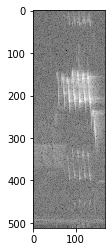

In [20]:
N = 2
plt.imshow(np.flipud(spec.detach().cpu().numpy()[N, :,:]), cmap='gray')
ipd.Audio(X.detach().cpu().numpy()[N].reshape(-1), rate=22050)

In [21]:
min_std = 0.5
N = 7
duration = 2
dgen_train = DataGeneratorV2(list(train_files)*N, list(train_labels)*N, min_std=min_std, batch_size=32, chunk_seconds=duration, channel_first=True, one_hot=False)
dgen_val = DataGeneratorV2(list(val_files)*N, list(val_labels)*N, min_std=min_std, batch_size=32, chunk_seconds=duration, channel_first=True, one_hot=False)

{'aldfly': 0, 'amecro': 1, 'amegfi': 2, 'amepip': 3, 'amered': 4, 'amerob': 5, 'annhum': 6, 'astfly': 7, 'balori': 8, 'banswa': 9}
{'aldfly': 0, 'amecro': 1, 'amegfi': 2, 'amepip': 3, 'amered': 4, 'amerob': 5, 'annhum': 6, 'astfly': 7, 'balori': 8, 'banswa': 9}


In [48]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    
    return correct_pred.sum(), len(correct_pred)

def validate(dgen_val):
    model.eval()  
    with torch.no_grad():
        running_loss = 0.0
        total_ok = 0
        total_predictions = 0
        batches_per_epoch = len(dgen_val)
        for i, (X, y) in enumerate(dgen_val):
            inputs, labels = torch.from_numpy(X).float().to(device), torch.from_numpy(y).long().to(device)
            _, y_pred = model(inputs)
            loss = criterion(y_pred, labels)
            ok, total = multi_acc(y_pred, labels)
            total_ok = total_ok + ok
            running_loss = running_loss + loss
            total_predictions = total_predictions + total
            print(f'\r{i+1}/{batches_per_epoch} - loss: {running_loss/(i+1)}, acc: {total_ok/total_predictions}', end='')
    model.train()
    return (running_loss/(i+1)).detach().item(), (total_ok/total_predictions).detach().item()

In [49]:
# def evaluate(model, validation_loader, use_cuda=True):
#     model.eval()        
#     with torch.no_grad():
#         acc = .0
#         for i, data in enumerate(validation_loader):
#             X = data[0]
#             y = data[1]
#             if use_cuda:
#                 X = X.cuda()
#                 y = y.cuda()
#             predicted = model(X)
#             acc+=(predicted.round() == y).sum()/float(predicted.shape[0])       
#     model.train()
#     return (acc/(i+1)).detach().item()

In [50]:
LEARNING_RATE = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [54]:
def train_model(dataset, epochs=1):
    model.train()
    batches_per_epoch = len(dataset)

    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        total_ok = 0
        total_predictions = 0
        for i, (X, y) in enumerate(dataset):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = torch.from_numpy(X).float().to(device), torch.from_numpy(y).long().to(device)
            # (1) Initialise gradients
            optimizer.zero_grad()
            # (2) Forward pass
            _, y_pred = model(inputs)
            loss = criterion(y_pred, labels)
            running_loss = running_loss + loss
            # (3) Backward
            loss.backward()
            # (4) Compute the loss and update the weights
            optimizer.step()
            ok, total = multi_acc(y_pred, labels)
            total_ok = total_ok + ok
            total_predictions = total_predictions + total
            print(f'\r{epoch+1}/{epochs} - {i+1}/{batches_per_epoch} - loss: {running_loss/(i+1)}, acc: {total_ok/total_predictions}', end='')
        print()

In [ ]:
train_model(dgen_train, 20)

1/20 - 41/173 - loss: 2.0813674926757812, acc: 0.26143291592597963

In [46]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [47]:
loss, acc = validate(dgen_val)

38/39 - loss: 21.913867950439453, acc: 0.11217948794364929

In [40]:
torch.save(model.state_dict(), 'test.pth')

In [ ]:
X_img = torch.from_numpy(np.random.rand(2, 1, 44100)).float()